## Lecture 12: Fed-Batch Reactor Simulation
## CHME 5630 - Spring 2020
This notebook goes through the steps involved in simulating a fed-batch reactor. It extends the basic use of *odeint* to include modifications to the system of ODEs based on the current output while the solver is running. Essentially we are setting up automated process control. In this case, we will be detecting the DO spike associated with substrate ininital substrate depeltion, and at that point turning on the feed pump with the concentrated sugar solution.

First, we import the packages we need:

In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

Next, we'll define the variables we will need, starting with the kinetic and process parameters

In [75]:
mu_max = 0.89 # 1/hr
Ks_glucose = 0.1 #g/L
Ks_oxygen = 0.05 #mmol/L
Y_X_S = 0.4 #gdw/g glucose
Y_X_O2 = 0.1#0.032 #gdw/mmol O2
Q_O2 = 0#19.8 #mmol O2/hr
kLa = 800.0 #1/hr
PO2 = 1.0 #atm
kH = 756.7 #l-atm/mol
C_eq = PO2/kH * 1000.0 #mmol/L
gluc_feed = 100.0 #g/L
feed_rate = 2.0 #l/hr

Now we define our derivative functions (one each for cells, substrate, and O2), which we get from the mass balances,

$$\frac{dX}{dt}=\frac{X(V\mu-\frac{dV}{dt})}{V}$$

$$\frac{dS}{dt}=\frac{FS_{feed}-\frac{XV\mu }{Y_{X/S}}-S\frac{dV}{dt}}{V}$$

$$\frac{dO2}{dt}=\frac{k_La(C_{eq}-O_2)-\frac{XV\mu }{Y_{X/O2}}-XVq_{O2}-O_2\frac{dV}{dt}}{V}$$

Remember that $\mu$ is a function of S and O2, according to:

$$\mu = \mu_{max}\frac{S}{K_S+S}\frac{O_2}{K_S+O_2}$$

We also need to define our feed rate as a piecewise function. Before the O2 spike, there is no feed, and 

$$\frac{dV}{dt}=0$$.

After the O2 spike, the pump will be turned on at a constant rate (F), such that 

$$\frac{dV}{dt}=F$$

In [76]:
def deriv(t, y):
    V = y[0]
    X = y[1]
    S = y[2]
    O2 = y[3]
    
    mu = mu_max * S / (Ks_glucose + S) * O2 / (Ks_oxygen + O2)
    
    ##If the pump isn't already on, detect the substrate depletion, and turn on the pump
    #if feed_on == "off" and S < S_threshold:
    #    feed_on = "on"
    
    #if feed_on == "on": #If the trigger for the feed is on (1), then set pump to on
    #    dVdt = F
    #else:
    #    dVdt = 0.0
    F = F_on*feed_rate
    
    dVdt = F    
    dXdt = (X * V * mu - X * dVdt) / V
    dSdt = (F * gluc_feed - X * V * mu / Y_X_S - S * dVdt) / V
    dO2dt = (kLa* (C_eq - O2) - Q_O2 * X * V - X * V * mu / Y_X_O2 - O2 * dVdt) / V
    
    return dVdt, dXdt, dSdt, dO2dt

##### Now we generate a list of timepoints for which we want the solver to give us values of P and S. We just want linearly spaced time points between 0 and 5 hours

In [77]:
t_span = np.linspace(0, 5.0, 200) #200 evenly spaced points betweeen 0 and 1400
t_span

array([0.        , 0.02512563, 0.05025126, 0.07537688, 0.10050251,
       0.12562814, 0.15075377, 0.1758794 , 0.20100503, 0.22613065,
       0.25125628, 0.27638191, 0.30150754, 0.32663317, 0.35175879,
       0.37688442, 0.40201005, 0.42713568, 0.45226131, 0.47738693,
       0.50251256, 0.52763819, 0.55276382, 0.57788945, 0.60301508,
       0.6281407 , 0.65326633, 0.67839196, 0.70351759, 0.72864322,
       0.75376884, 0.77889447, 0.8040201 , 0.82914573, 0.85427136,
       0.87939698, 0.90452261, 0.92964824, 0.95477387, 0.9798995 ,
       1.00502513, 1.03015075, 1.05527638, 1.08040201, 1.10552764,
       1.13065327, 1.15577889, 1.18090452, 1.20603015, 1.23115578,
       1.25628141, 1.28140704, 1.30653266, 1.33165829, 1.35678392,
       1.38190955, 1.40703518, 1.4321608 , 1.45728643, 1.48241206,
       1.50753769, 1.53266332, 1.55778894, 1.58291457, 1.6080402 ,
       1.63316583, 1.65829146, 1.68341709, 1.70854271, 1.73366834,
       1.75879397, 1.7839196 , 1.80904523, 1.83417085, 1.85929

In [78]:
#Define initial conditions
V0 = 10.0 #L
X0 = 0.2 #g/L
S0 = 20 #g/L
O20 = C_eq
y0 = [V0, X0, S0, O20] #Define our initial conditions

S_threshold = 0.01

def out_of_substrate(t, y): return y[2]-S_threshold
out_of_substrate.terminal = True

#INtegrate the ode, triggering termination when substrate hits the pre-determined threshold
F_on = 0.0
sol = solve_ivp(deriv, (0,5), y0, events=out_of_substrate)

#Convert the solution to a standard numpy array
np_sol = np.asarray(sol.y)

In [79]:
#Store the time at which the event was triggered
t_out_of_substrate = float(sol.t_events[0])
t_out_of_substrate

4.43595342478025

In [80]:
#Integrate the ODE from the time determined above, now with a feed

init_feed = np_sol[:,-1] #Set the end of the previous simulation as the start point for the next one

F_on = 1.0
sol_feed = solve_ivp(deriv, (0,5), init_feed)

In [81]:
#Combine both solutions
np_sol_feed = np.asarray(sol_feed.y)
np_sol_total = np.concatenate((np_sol, np_sol_feed), 1)
t_feed = sol_feed.t + t_out_of_substrate
t_total = np.concatenate((sol.t, t_feed))

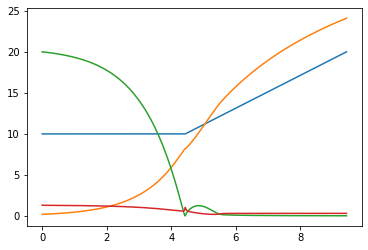

In [82]:
for i in range (0,4):
    plt.plot(t_total, np_sol_total[i,:])

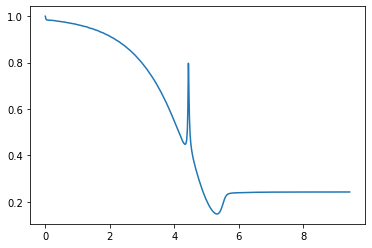

In [83]:
plt.plot(t_total, np_sol_total[3,:]/C_eq)